In [1]:
import datetime as dt
import random
import re

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook+plotly_mimetype"
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [48]:
charts = pd.read_pickle('alltime_top_100')

## Data Handling

In [49]:
# Convert start_date and end_date to datetime objects
charts['start_date']= pd.to_datetime(charts['start_date'], format='%d.%m.%Y')
charts['end_date']= pd.to_datetime(charts['end_date'], format='%d.%m.%Y')

In [50]:
# Add column week
charts['week'] = charts['start_date'].dt.week

In [51]:
# Add column year
charts['year'] = charts['start_date'].dt.year

In [52]:
# Add combination of artist and song (easier for plotting purposes later)
charts['artist_song'] = charts['artist'] + ' - ' + charts['song']

In [53]:
# Add column with peak position of the song during the year
tracks = charts.artist_song.unique()
peak_positions = charts.groupby(['artist_song'])['position'].min()

for track in tracks:
    charts.loc[charts['artist_song'] == track, 'peak'] = int(peak_positions[track])

In [54]:
# Add column to mark if a song was in the top10 during the year (1: yes, 0: no)
charts.loc[charts['peak'] <= 10, 'top10'] = 1
charts.loc[charts['peak'] > 10, 'top10'] = 0

In [55]:
# Change position into dtype int
charts['position'] = charts['position'].astype(int)

In [56]:
# Delete duplicates
charts.drop_duplicates(keep='first',inplace=True)

In [57]:
# sort values by start date and position
charts.sort_values(['start_date', 'position'], ignore_index=True, inplace=True)

In [60]:
# add decade
charts.loc[charts['year'] < 2020, 'decade'] = '2010s'
charts.loc[charts['year'] < 2010, 'decade'] = '2000s'
charts.loc[charts['year'] < 2000, 'decade'] = '1990s'
charts.loc[charts['year'] < 1990, 'decade'] = '1980s'
charts.loc[charts['year'] < 1980, 'decade'] = '1970s'

In [61]:
charts

artist  \
0                                                   ABBA   
1                                           David Dundas   
2                                               Boney M.   
3                                               Boney M.   
4                                                Chicago   
...                                                  ...   
201945                                     Michael Bublé   
201946                                        Apache 207   
201947                    The Cratez, Luciano & Kontra K   
201948  The Kingdom Choir feat. Camélia Jordana & Namika   
201949                                          Boney M.   

                                 song             label  position start_date  \
0                 Money, Money, Money                           1 1977-01-03   
1                            Jeans On                           2 1977-01-03   
2                               Sunny                           3 1977-01-03   
3                          Daddy Cool                           4 1977-01-03   
4                 If You Leave Me Now                           5 1977-01-03   
...                               ...               ...       ...        ...   
201945  Santa Claus Is Coming To Town           Reprise        96 2019-12-27   
201946                    Sex mit dir   SME - Two Sides        97 2019-12-27   
201947                    Himmel grau         SME - RBK        98 2019-12-27   
201948            Holidays Are Coming  SME - Sony Music        99 2019-12-27   
201949  Mary's Boy Child / Oh My Lord  SME - Sony Music       100 2019-12-27   

         end_date  week  year  \
0      1977-01-09     1  1977   
1      1977-01-09     1  1977   
2      1977-01-09     1  1977   
3      1977-01-09     1  1977   
4      1977-01-09     1  1977   
...           ...   ...   ...   
201945 2020-01-02    52  2019   
201946 2020-01-02    52  2019   
201947 2020-01-02    52  2019   
201948 2020-01-02    52  2019   
201949 2020-01-02    52  2019   

                                              artist_song  peak  top10 decade  
0                              ABBA - Money, Money, Money   1.0    1.0  1970s  
1                                 David Dundas - Jeans On  10.0    1.0  1970s  
2                                        Boney M. - Sunny   1.0    1.0  1970s  
3                                   Boney M. - Daddy Cool  14.0    0.0  1970s  
4                           Chicago - If You Leave Me Now  10.0    1.0  1970s  
...                                                   ...   ...    ...    ...  
201945      Michael Bublé - Santa Claus Is Coming To Town  66.0    0.0  2010s  
201946                           Apache 207 - Sex mit dir  13.0    0.0  2010s  
201947       The Cratez, Luciano & Kontra K - Himmel grau  11.0    0.0  2010s  
201948  The Kingdom Choir feat. Camélia Jordana & Nami...  99.0    0.0  2010s  
201949           Boney M. - Mary's Boy Child / Oh My Lord   1.0    1.0  2010s  

[201950 rows x 12 columns]

In [62]:
charts.head()

artist                 song label  position start_date   end_date  \
0          ABBA  Money, Money, Money               1 1977-01-03 1977-01-09   
1  David Dundas             Jeans On               2 1977-01-03 1977-01-09   
2      Boney M.                Sunny               3 1977-01-03 1977-01-09   
3      Boney M.           Daddy Cool               4 1977-01-03 1977-01-09   
4       Chicago  If You Leave Me Now               5 1977-01-03 1977-01-09   

   week  year                    artist_song  peak  top10 decade  
0     1  1977     ABBA - Money, Money, Money   1.0    1.0  1970s  
1     1  1977        David Dundas - Jeans On  10.0    1.0  1970s  
2     1  1977               Boney M. - Sunny   1.0    1.0  1970s  
3     1  1977          Boney M. - Daddy Cool  14.0    0.0  1970s  
4     1  1977  Chicago - If You Leave Me Now  10.0    1.0  1970s

## Top Artists

In [71]:
# Number of times an artist appears in the charts for the year
counts = charts['artist'].value_counts().rename_axis('artist').reset_index(name='counts')


# Limit number of artists to the ones appearing more than 40 ones
top_artists = counts[counts['counts'] >= 250]

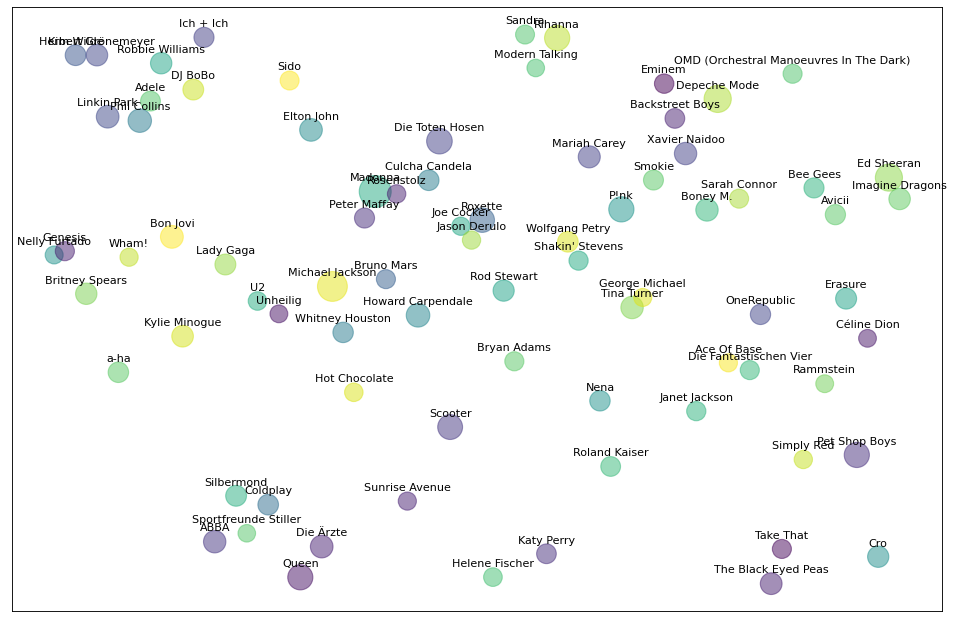

In [72]:
#Draw plot
plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

top_artists = top_artists.sample(frac=1)       # randomize position on the x-axis

x = top_artists['artist']
y = np.random.rand(len(x))                     # randomize position on the y-axis
colors = np.random.rand(len(x))                # randomize colors

plt.scatter(x, y,
            marker='o',
            s=top_artists['counts'],        # marker size depends on the number of times artist appears
            alpha=0.5,
            c=colors)


# Label points with artist name, called for each point
for i,j in zip(x,y):
    label = i
    plt.annotate(label,                        # this is the text
                 (i,j),                        # this is the point to label
                 textcoords="offset points",   # how to position the text
                 xytext=(0,10),                # distance from text to points (x,y)
                 ha='center')                  # horizontal alignment can be left, right or center

plt.xticks([], [])
plt.yticks([], [])

plt.show()

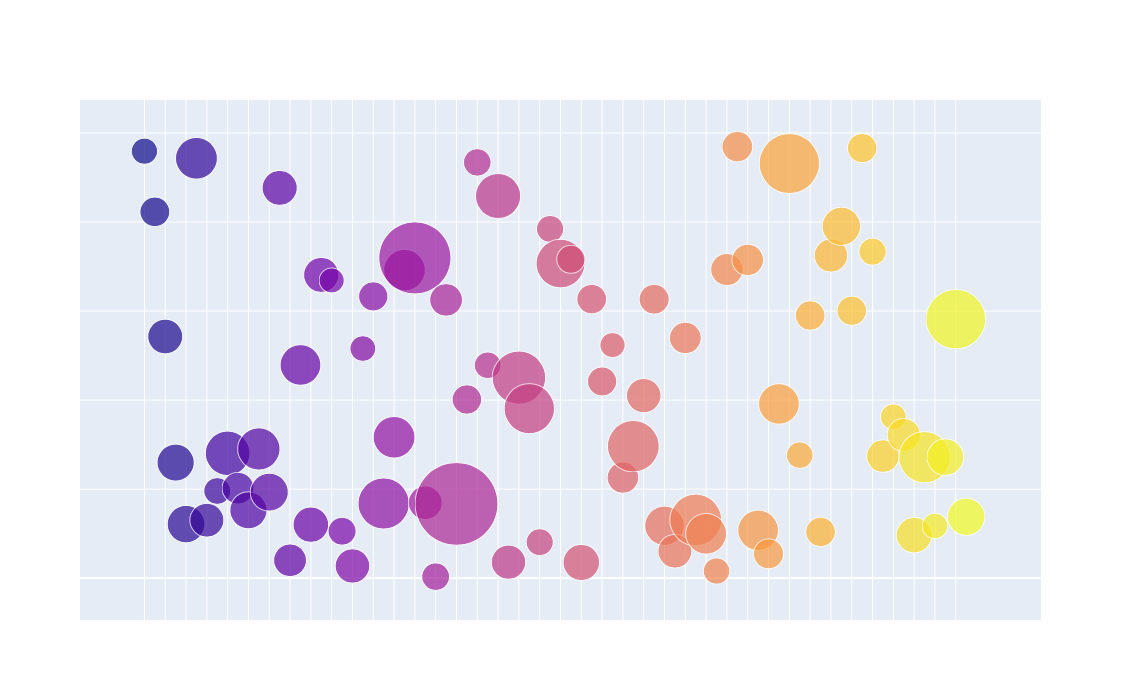

In [75]:
import plotly.graph_objects as go

c = list(range(len(x)))

fig = go.Figure(data=go.Scatter(
    x=top_artists['artist'],
    y=np.random.rand(len(x)),
    mode='markers',
    marker=dict(size=top_artists['counts']/10,
                color=c),
    hovertext=top_artists['artist'],
    hoverinfo="text"
))

fig.update_layout(
    xaxis = dict(showticklabels=False),
    yaxis = dict(showticklabels=False),
    width=1000,
    height=700
)

fig.show()

## Songs by Artist

In [76]:
# Function to see development of all songs by one artist during the year

def info_artist(artist_name):
    # Filter dataframe by requested artist
    df = charts[charts['artist'] == artist_name].sort_values(by='start_date').copy()
    # Select all songs by artist
    tracks = df.song.unique()
    
    plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    
    # Draw plot for each track
    for track in tracks:
        x = df[df['song'] == track]['start_date']
        y = df[df['song'] == track]['position']
        plt.scatter(x, y,
                    marker='o',
                    s=1000-y*10,   # marker size depends on the position of the track in the charts
                    alpha=.5,
                    label=track)

    plt.yticks(np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

    plt.legend(numpoints=1)

    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()

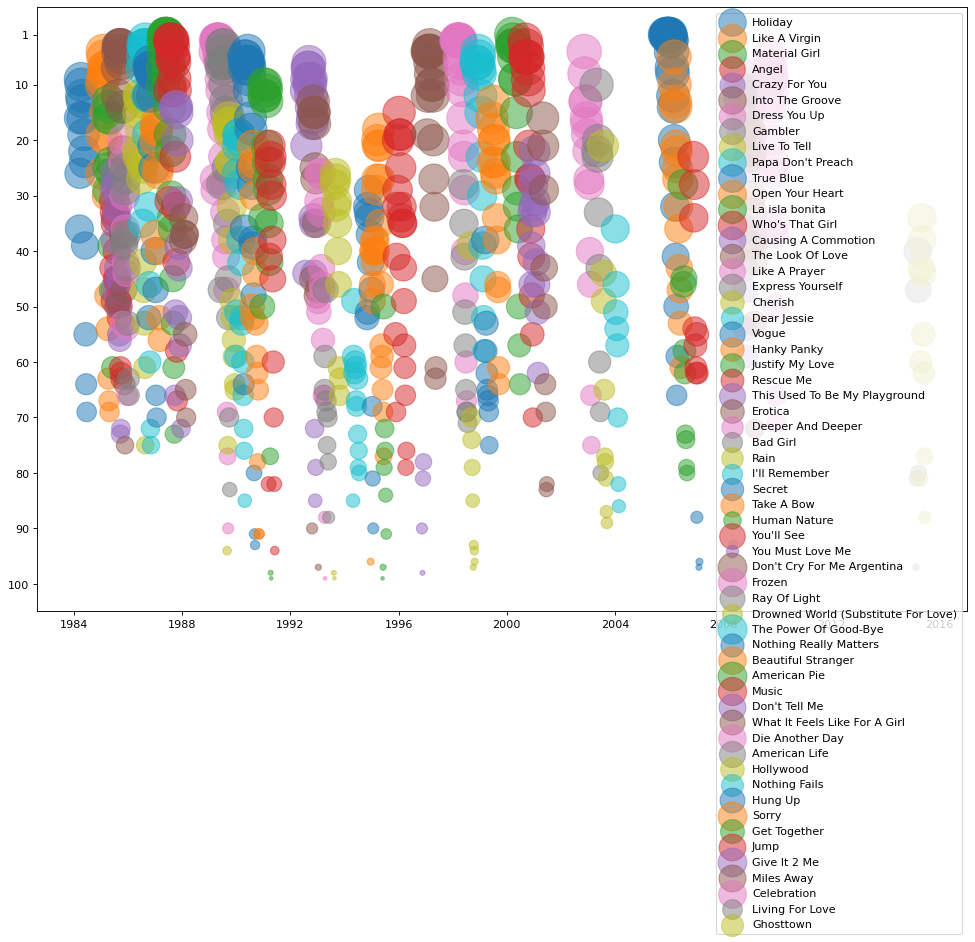

In [79]:
# Example
info_artist('Madonna')

## No.1 Songs

In [80]:
# songs at the moment they were No.1
peak_position = charts['position'] == 1
peaks = charts[peak_position]

# all songs that were at least one week No.1
ones = charts['peak'] == 1
ones_other = charts[ones]

#### No.1 Songs during the Year

In [83]:
# Determine limits for x-axis
min_date = ones_other.start_date.min()
max_date = ones_other.end_date.max()

# Draw plot
fig, ax = plt.subplots(figsize=(160,100), dpi= 80)
ax.hlines(y=ones_other['artist_song'], xmin=min_date, xmax=max_date, color='gray', alpha=0.3, linewidth=0.5, linestyles='dashdot')
ax.scatter(y=peaks['artist_song'], x=peaks['start_date'], color='#0e668b', s=75)
ax.scatter(y=ones_other['artist_song'], x=ones_other['start_date'], s=75, color='#a3c4dc', alpha=0.3)

# Title
ax.set_title('No.1 songs', fontdict={'size':22})
plt.show()

#### No.1 weeks in charts

In [84]:
# Number of weeks song was in Top100
weeks_top100 = charts[ones].groupby(['artist_song'], as_index=False).count()[['artist_song', 'week']]

# Number of weeks song was on No.1
weeks_no1 = charts[peak_position].groupby(['artist_song'], as_index=False).count()[['artist_song', 'week']]

weeks = weeks_top100.merge(weeks_no1, how='left', on='artist_song')

weeks.columns = ['artist_song', 'weeks_in_charts', 'weeks_on_one']
weeks.sort_values(by=['weeks_in_charts'], inplace=True)
weeks.tail()

artist_song  weeks_in_charts  \
156                               Ed Sheeran - Perfect               84   
461                             Silbermond - Das Beste               85   
140                   Die Toten Hosen - Tage wie diese               85   
157                          Ed Sheeran - Shape Of You               91   
119  DJ Ötzi & Nik P. - Ein Stern (... der deinen N...              107   

     weeks_on_one  
156            10  
461             7  
140             5  
157            15  
119            11

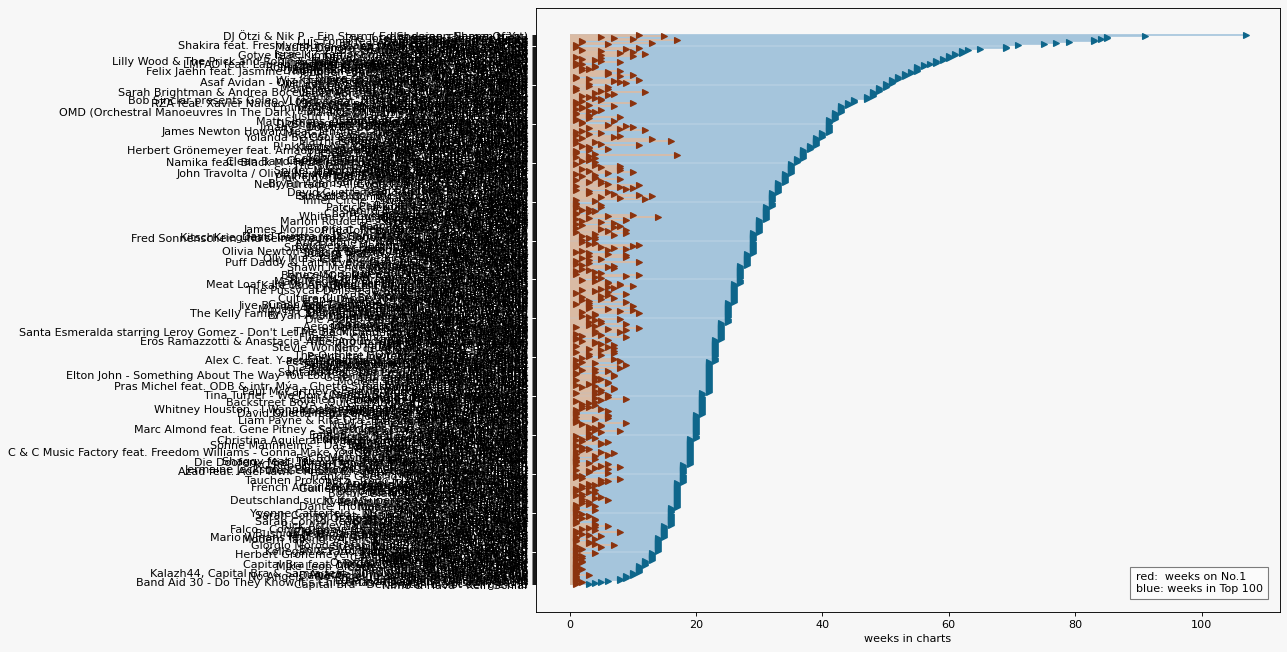

In [85]:
# Draw plot
fig, ax = plt.subplots(1,1,figsize=(12,10), facecolor='#f7f7f7', dpi= 80)

# Plot weeks in charts
plt.hlines(y=weeks['artist_song'], xmin=0, xmax=weeks['weeks_in_charts'], color='#a3c4dc')
plt.plot(weeks['weeks_in_charts'], weeks['artist_song'], ">", color='#0e668b')

# Plot weeks on 1
plt.hlines(y=weeks['artist_song'], xmin=0, xmax=weeks['weeks_on_one'], color='#dcbba3')
plt.plot(weeks['weeks_on_one'], weeks['artist_song'], ">", color='#8b330e')

ax.set_facecolor('#f7f7f7')
ax.set_xlabel('weeks in charts')
plt.figtext(0.75, 0.15, "red:  weeks on No.1\nblue: weeks in Top 100", ha="left", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.show()

## Song Titles

In [97]:
import itertools
import collections
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [98]:
# removing special characters
special_characters = ['!', '?', '#', '/', '(', ')', '&', '%', '$', '*', '+']
title = charts.song

for char in special_characters:
    title = title.str.replace(char, '')

In [99]:
# extract words from song titles
#words_in_title = [song.lower().split() for song in title.unique()]     # for words in unique titles
words_in_title = [song.lower().split() for song in title]               # for words in titles depending appearance in charts
words_in_title[:5]

[['money,', 'money,', 'money'],
 ['jeans', 'on'],
 ['sunny'],
 ['daddy', 'cool'],
 ['if', 'you', 'leave', 'me', 'now']]

In [135]:
# List of all words across title
all_words = list(itertools.chain(*words_in_title))

# Create counter
count_words = collections.Counter(all_words)

# Remove stopwords
stop_words = STOPWORDS

# Add Christmas to stopword
stop_words.update(['christmas', 'ich', 'du', 'er', 'sie', 'es', 'wir', 'ihr', 'der', 'die', 'das', 'mich', 'dich', \
                   'uns', 'ist', 'ein', 'nicht', 'man', 'von', 'da', 'mit', 'dir', 'im', 'den', 'dem', 'mir', 'bist', \
                   'wie', 'zu', 'aus', 'bin', 'auf', 'mein', 'und'])

titles_nsw = [[word for word in title_words if not word in stop_words]
              for title_words in words_in_title]

all_words = list(itertools.chain(*titles_nsw))

# count word without stopword
counts_nsw = collections.Counter(all_words)

# Top ten most used words
counts_nsw.most_common(10)

[('love', 10601),
 ('one', 2299),
 ('heart', 2116),
 ('time', 1941),
 ('life', 1880),
 ('la', 1880),
 ('go', 1858),
 ('night', 1858),
 ('girl', 1587),
 ('world', 1544)]

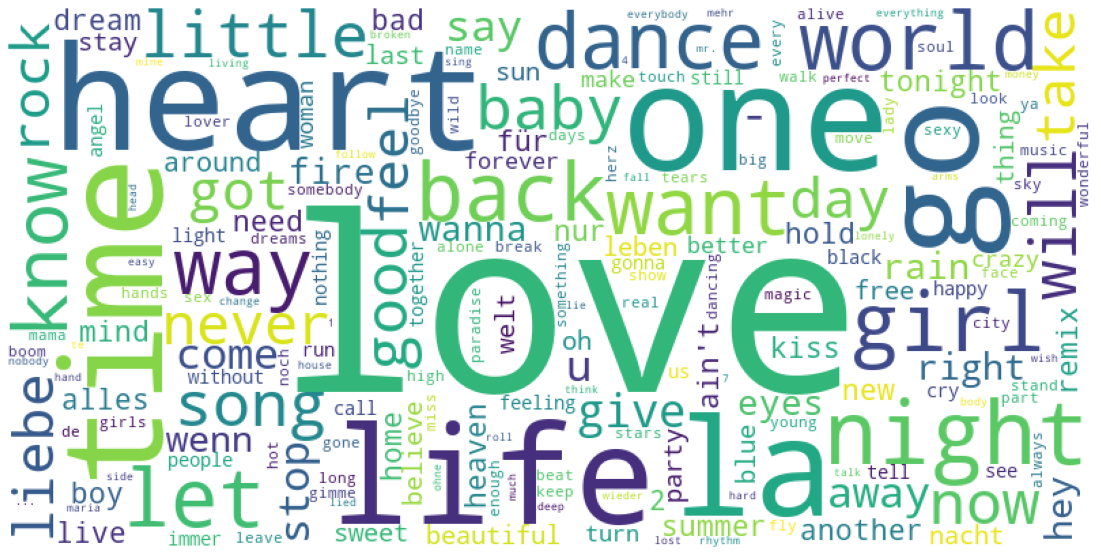

In [136]:
# Create and generate a word cloud image:
wordcloud = WordCloud(
                max_font_size=180,
                max_words=200,
                stopwords=stop_words,
                background_color="white",
                width=800,
                height=400
                ).fit_words(counts_nsw)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Uncomment to save image
#plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

# Save the image in the img folder:
#wordcloud.to_file("2019_titles.png")

In [ ]:
#charts[charts['song'].str.contains('Christmas')].groupby(['song']).max().sort_values(by='position', ascending=True)

## Artists

In [ ]:
charts.head()

In [ ]:
top10 = charts[charts['top10'] == 1]
top10_artist = top10.groupby(['artist', 'song']).count().groupby(['artist']).count()[['top10']]
top10_artist[top10_artist['top10']>=3].plot(kind='barh', figsize=(10, 8))

In [ ]:
charts['artist_song'].nunique()

In [ ]:
year_1978 = pd.read_pickle('1978_top_100')
year_1978.head()